In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import get_tstamp
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_squared_error

matplotlib.rcParams.update({'font.size': 16})

data_dir='/fd1/QibinShi_data/England_farm/'
spatial_data = os.path.join(data_dir, 'interp_dv_b_tillage_tire.csv')
merged_dv_met = os.path.join(data_dir, 'interp_dvv_temp_moisture.hdf5')
psd_data = os.path.join(data_dir, 'psd_all.hdf5')
harper_met = 'NewportSalop_merged.csv'
reg_met = 'met_newport.csv'


## Spatial Pattern: Mechanical Damage by Tillage and Tire compaction

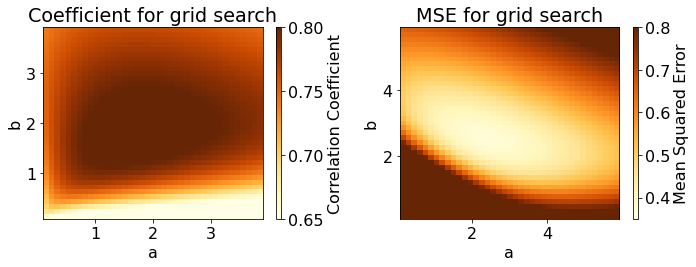

Largest correlation coefficient: 0.8149976434195801
Best a: 1.8000000000000003
Best b: 1.7000000000000002
Smallest mean squared error: 0.3707105896597401
Best a: 1.7000000000000002
Best b: 1.6


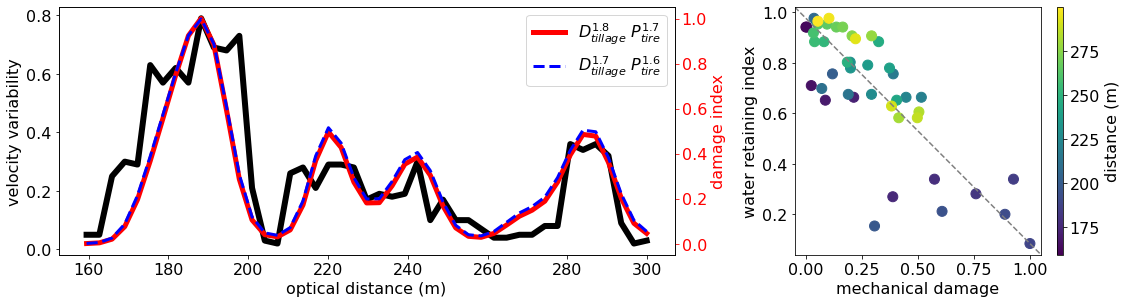

cross-corr: 0.8147985375501663
mse: 0.3707105896597401


In [2]:
### Read the data from the interpolated file
tillage_interpolated = pd.read_csv(spatial_data)['tillage_depth'].to_numpy()
tire_interpolated = pd.read_csv(spatial_data)['tire_pressure'].to_numpy()
dvv_variability = pd.read_csv(spatial_data)['dvv_varibility'].to_numpy()

def compute_misfit(a, b, tillage_interpolated, tire_interpolated, dvv_variability):
    scaled_mechanical = np.power(tillage_interpolated, a) * np.power(tire_interpolated, b)
    scaled_mechanical = scaled_mechanical/np.std(scaled_mechanical)
    scaled_variability =dvv_variability/np.std(dvv_variability)
    correlation = np.corrcoef(scaled_variability, scaled_mechanical)[0, 1]
    mse = mean_squared_error(scaled_variability, scaled_mechanical)
    return correlation, mse, scaled_mechanical, scaled_variability

### define a loop for gridsearch
# Create a grid of a and b values
a_values = np.arange(0.1, 4, 0.1)
b_values = np.arange(0.1, 4, 0.1)
correlation_matrix = np.zeros((len(a_values), len(b_values)))
mse_matrix = np.zeros((len(a_values), len(b_values)))

# Compute the correlation for each combination of a and b
for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        correlation, mse, _, _ = compute_misfit(a, b, tillage_interpolated, tire_interpolated, dvv_variability)
        correlation_matrix[i, j] = correlation
        mse_matrix[i, j] = mse
        

# Plot the correlation matrix and MSE matrix as subfigures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

# Correlation matrix
cax1 = ax1.imshow(correlation_matrix, extent=[0.1, 3.9, 0.1, 3.9], origin='lower', aspect='auto', cmap='YlOrBr', vmin=0.65, vmax=0.8)
fig.colorbar(cax1, ax=ax1, label='Correlation Coefficient', aspect=40)
ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_title('Coefficient for grid search')

# MSE matrix
cax2 = ax2.imshow(mse_matrix, extent=[0.1, 5.9, 0.1, 5.9], origin='lower', aspect='auto', cmap='YlOrBr', vmin=0.35, vmax=0.8)
fig.colorbar(cax2, ax=ax2, label='Mean Squared Error', aspect=40)
ax2.set_xlabel('a')
ax2.set_ylabel('b')
ax2.set_title('MSE for grid search')

plt.show()
# Find the indices of the maximum correlation coefficient
max_corr_index = np.unravel_index(np.argmax(correlation_matrix, axis=None), correlation_matrix.shape)
max_corr = correlation_matrix[max_corr_index]
best_a = a_values[max_corr_index[0]]
best_b = b_values[max_corr_index[1]]

print(f"Largest correlation coefficient: {max_corr}")
print(f"Best a: {best_a}")
print(f"Best b: {best_b}")

mse_index = np.unravel_index(np.argmin(mse_matrix, axis=None), mse_matrix.shape)
min_mse = mse_matrix[mse_index]
best_a_mse = a_values[mse_index[0]]
best_b_mse = b_values[mse_index[1]]

print(f"Smallest mean squared error: {min_mse}")
print(f"Best a: {best_a_mse}")
print(f"Best b: {best_b_mse}")

### plot the spatial variability
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4.5), gridspec_kw={'width_ratios': [2, 1]}, tight_layout=True)

# Plot scaled variability and mechanical damage
ax1.plot((np.arange(45)+50)*3.19, dvv_variability, label='variability', lw=6, color='k')
ax1.set_xlabel("optical distance (m)", fontsize=16)
ax1.set_ylabel("velocity variability", fontsize=16)
twinx = ax1.twinx()

correlation, mse, scaled_mechanical, scaled_variability = compute_misfit(best_a, best_b, tillage_interpolated, tire_interpolated, dvv_variability)    
twinx.plot((np.arange(45)+50)*3.19, scaled_mechanical/4, label='$D_{tillage}^{1.8}~P_{tire}^{1.7}$', lw=5, color='red')
correlation, mse, scaled_mechanical, scaled_variability = compute_misfit(best_a_mse, best_b_mse, tillage_interpolated, tire_interpolated, dvv_variability)  
twinx.plot((np.arange(45)+50)*3.19, scaled_mechanical/4, label='$D_{tillage}^{1.7}~P_{tire}^{1.6}$', lw=3, color='blue', linestyle='--')  
twinx.set_ylabel("damage index", fontsize=16, color='red')
twinx.tick_params(axis='y', colors='red')
twinx.legend(loc='upper right')

# Pick several locations
# channel_list = [12, 40, 7, 24]
# for ch in channel_list:
#     ax1.scatter([ch], [scaled_mechanical[ch]], color='k', s=100)
#     print(tillage_interpolated[ch], tire_interpolated[ch])


# Covariance plot
damage_index = scaled_mechanical/4
ax2.plot([0, 1], [1, 0], transform=ax2.transAxes, color='gray', linestyle='--')
cax = ax2.scatter(damage_index, 1 - scaled_variability/4, s=100,  cmap='viridis', c=(np.arange(45)+50)*3.19)
ax2.set_ylabel("water retaining index", fontsize=16)
ax2.set_xlabel("mechanical damage", fontsize=16)
fig.colorbar(cax, ax=ax2, label='distance (m)', aspect=40)


plt.show()

print(f"cross-corr: {correlation}")
print(f"mse: {mse}")

## Temporal Evolution: hydrological and lithological models

In [3]:
## This model use the actual weather data to account for the evaporation
## The moisture at depth is forward modelled to account for the drainage and evaporation
## The PSD data is calibrated to model the water increase due to the rain
###  Basic extraterrestrial radiation model
def rad_a_shortterm(lat, lon, day, lz, time, duration):
    ## Short term radiation model
    ## lat, lon in degrees
    ## day in days from 1st Jan
    ## mid-point time in hours from 00:00
    ## lz in degrees
    ## duration in hours

    lat = np.radians(lat)

    ## Solar declination
    delta = 0.4093 * np.sin(2 * np.pi * day / 365 - 1.39)

    ## Sunset hour angle
    omega_s = np.arccos(-np.tan(lat) * np.tan(delta))

    ## Earth-Sun distance
    d = 1 + 0.033 * np.cos(2 * np.pi * day / 365)

    ## Seasonal correction
    b = 2 * np.pi * (day - 81) / 364
    Sc = 0.1645 * np.sin(2 * b) - 0.1255 * np.cos(b) - 0.025 * np.sin(b)

    ## Solar time angle at mid-point time
    omega = np.pi / 12 * (time + 0.06667 * (lon - lz) + Sc - 12)

    ## Solar time angle at beginning and end of the period
    omega1 = omega - duration * np.pi / 24
    omega2 = omega + duration * np.pi / 24

    ## Extra-terrestrial radiation for this period
    Ra = 12 * 60 / np.pi * 0.0820 * d * (
            (omega2 - omega1) * np.sin(lat) * np.sin(delta) + np.cos(lat) * np.cos(delta) * (np.sin(omega2) - np.sin(omega1)))
    
    return Ra

### reference ET model
def eto_shortterm(rad, T, wind, RH):
    ## Short term ETo model
    ## rad in MJ/m2/min
    ## T in C
    ## wind in m/s
    ## RH in %

    ## Saturation vapour pressure
    es = 0.6108 * np.exp(17.27 * T / (T + 237.3))

    ## Actual vapour pressure
    ea = es * RH / 100

    ## Slope of the saturation vapour pressure curve
    delta = 4098 * es / np.power(T + 237.3, 2)

    ## Psychrometric constant
    gamma = 0.665e-3 * 101.325

    ## ETo
    ETo = (0.408 * delta * rad + gamma * 900/24/60 / (T + 273) * wind * (es - ea)) / (delta + gamma * (1 + 0.34 * wind))

    return ETo


class hydro0:
    def __init__(self, prec, porosity, s0, T, I, etc, damage_index, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s0
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.etc = etc
        self.damage = damage_index
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length

        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239


    def get_s_history(self):

        s_history = np.zeros(self.length)

        for i in range(self.length):
            ## evaporation
            # self.pet = 1.6 * np.power((10*self.T[i] / self.I), self.a)
            self.evap = self.s * self.etc[i] * self.damage ## Evaporation rate

            ## drainage
            self.drain = self.prec[i] * self.s * self.damage  ## Drainage rate

            prec_rate = self.A_p * self.prec[i]
            evap_rate = self.A_e * self.evap
            drain_rate = self.A_d * self.drain

            s_rate = prec_rate - evap_rate - drain_rate
            
            self.s += s_rate
            s_history[i] = self.s

        return s_history
    

class litho:
    def __init__(self, bulk_density, porosity, N, f, s, s_wr, tau, igore_capillary=False):
        self.rho_d = bulk_density
        self.phi = porosity  ## derived from rho_d, actually
        self.N = N  ## number of contacts
        self.f = f  ## non-slip fraction
        self.s = s  ## Saturation (water / (air + water))
        self.s_wr = s_wr  ## residual saturation
        self.tau = tau  ## dynamic coefficient of capillary pressure

        ## Solid grains
        self.rho_s = 2650 # kg/m^3
        self.K_s = 37e9 # Pa
        self.G_s = 44e9 # Pa

        ## Water
        self.rho_w = 1000
        self.K_w = 2.2e9  ## by Copilot

        ## Air
        self.rho_a = 1.2  ## kg/m^3
        self.K_a = 1e5  ## by Copilot

        ## Water-air mixture
        self.K_f = 1 / (self.s / self.K_w  +  (1-self.s) / self.K_a)

        ## Effective density of the soil
        self.rho = (1-self.phi)*self.rho_s + self.phi*(self.s*self.rho_w + (1-self.s)*self.rho_a)

        ## Capillary and pore pressure
        if igore_capillary:  ## typical for fully saturated soil
            P_e = (self.rho - self.rho_w) * 9.8 * 0.1
        else:
            kai = (self.s - self.s_wr) / (1 - self.s_wr)
            s_rate = np.diff(self.s) / 60  ## Saturation rate, per second
            P_cdiff = np.concatenate((s_rate, [0])) * self.tau
            P_e = (self.rho - self.rho_a) * 9.8 * 0.1 - (self.rho_w - self.rho_a) * 9.8 * 0.1 * kai - P_cdiff

        ## Moduli of frame (Hertz-Mindlin) 
        nu = (3*self.K_s-2*self.G_s)/(2*(3*self.K_s+self.G_s))  ## Poisson's ratio
        self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
        self.G_d = 3 * self.K_d * (2+3*self.f-(1+3*self.f)*nu) / (2 - nu) / 5

    def get_vp_vs(self):
        
        self.K = self.K_d + (1-self.K_d/self.K_s)**2 / (self.phi/self.K_f + (1-self.phi)/self.K_s - self.K_d/self.K_s**2)
        self.G = self.G_d
        self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)
        self.vs = np.sqrt(self.G/self.rho)

        return self.vp, self.vs, self.K, self.G, self.rho

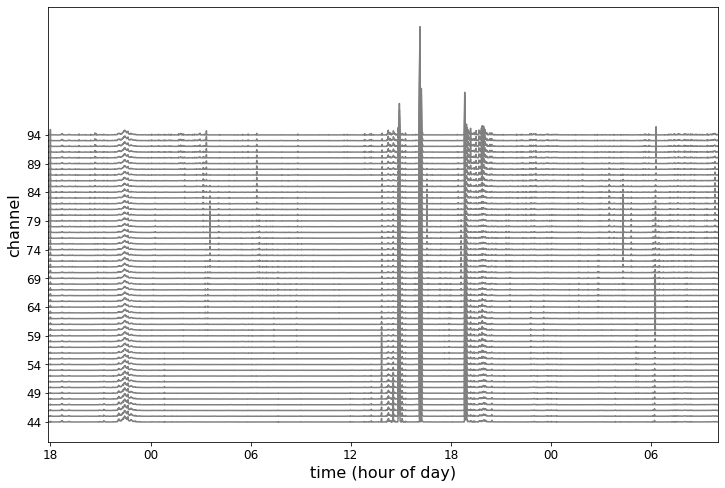

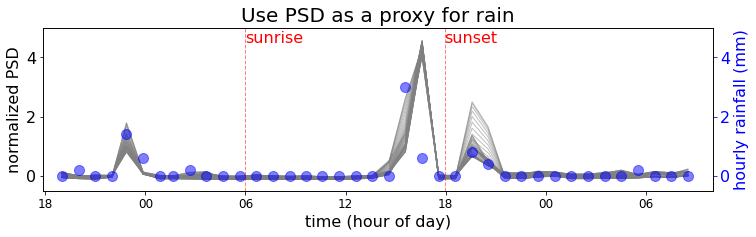

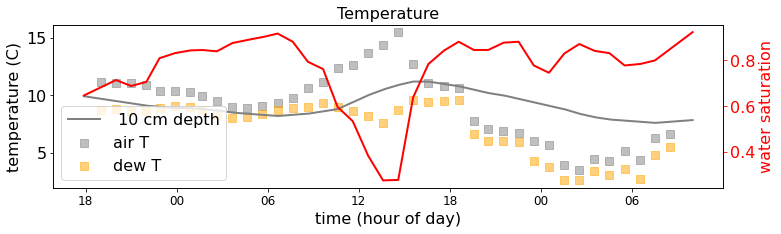

In [50]:
### Read the site weather data
csv_file = pd.read_csv(harper_met, low_memory=False).dropna(axis='columns', how='all')
j = 32   ## index of the beginning time
humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
grs_temp = csv_file['Grass Temperature'][j+1:j+40].to_numpy()
air_temp = csv_file['Dry Bulb Temperature'][j+1:j+40].to_numpy()
dew_temp = csv_file['Dew Point Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
rainfall = csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)
rain_diff[np.where(rain_diff<0)]=0

### PSD of high frequency DAS
with h5py.File(psd_data, 'r') as f:
    freq = f['frequency'][:]
    file_list = f['daslist'][:]
    PSD_all_time = f['psd_all_time'][:]
    
acqu_time = np.array([get_tstamp(i) for i in file_list.astype('U')])


## Index on the hour
hourly_index = [67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]


## Mean PSD over channels
ave_psd=np.mean(np.sum(PSD_all_time[0:44, :, 52:90], axis=-1) * (freq[1]-freq[0]), axis=0) - 0.0007

Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]


xax=np.arange(7, ave_psd.shape[-1], 360)
tax=acqu_time[7:ave_psd.shape[-1]:360]
hrax=[dt.strftime('%H') for dt in tax]

### Plot1
plt.figure(figsize=(12, 8))
plt.xlabel("time (hour of day)", fontsize = 16)
plt.ylabel("channel", fontsize = 16)
plt.yticks(np.arange(44,95,5), np.arange(44,95,5), fontsize = 12)
plt.xlim(0, ave_psd.shape[-1])
int_PSD=np.sum(PSD_all_time[:, :, 52:90], axis=-1) * (freq[1]-freq[0])
int_PSD=int_PSD / np.std(int_PSD, axis=1, keepdims=True)/20
int_PSD=gaussian_filter1d(int_PSD, 4, axis=0) - 0.003

for ch in range(51):
    plt.plot(np.arange(2408), int_PSD[ch, :]*12 + ch + 44, label='Ch{}'.format(ch), color='gray')
    plt.xticks(xax, hrax, fontsize = 12)


### Plot2
plt.figure(figsize = (12, 3))   
# plt.scatter(hourly_index, np.array(hr_psd), label='1-hour PSD', color='b', marker='*', s=100)
for ch in range(51):
    ## sum PSD over 1 hr window
    hr_psd=[]
    for ind in hourly_index:
        st_ind = int(ind - 60)
        ed_ind = st_ind + 60
        hr_psd.append(np.sum(int_PSD[ch, st_ind:ed_ind]))
    plt.plot(hourly_index, np.array(hr_psd), color='gray', lw=1, alpha=0.5)
# plt.plot(np.arange(ave_psd.shape[-1]), ave_psd*3, label='1-minute PSD (proxy of rain)', color='cyan', lw=2)
plt.xticks(xax, hrax, fontsize = 12)
plt.xlabel("time (hour of day)", fontsize = 16)
plt.ylabel("normalized PSD", fontsize = 16)
plt.title('Use PSD as a proxy for rain', fontsize = 20)  
plt.xlim(0, ave_psd.shape[-1])
plt.ylim(-0.5, 5)

plt.axvline(x = 726, color = 'red', linestyle='--', lw=1, alpha=0.5)
plt.axvline(x = 1443, color = 'red', linestyle='--', lw=1, alpha=0.5)
plt.text(726, 4.5, 'sunrise', color='r')
plt.text(1443, 4.5, 'sunset', color='r')
twinx = plt.twinx()
twinx.scatter(hourly_index, rain_diff, label='1-hour rainfall', color='b', marker='o', s=100, alpha=0.5)
twinx.set_ylabel("hourly rainfall (mm)", fontsize=16, color='b')
twinx.set_ylim(-0.5, 5)
twinx.tick_params(axis='y', colors='blue')

### Plot3
with h5py.File(merged_dv_met, 'r') as f:
    moisture = f['moisture'][:]
    dvv = f['dvv'][18]
    temp = f['temperature'][:]

s=moisture/100 * 2 - 1
    
plt.figure(figsize=(12, 3))
plt.plot(np.arange(2408), temp, color='gray', lw=2, label=' 10 cm depth')
plt.scatter(hourly_index, air_temp, label='air T', color='gray', marker='s', s=50, alpha=0.5)
plt.scatter(hourly_index, dew_temp, label='dew T', color='orange', marker='s', s=50, alpha=0.5)
# plt.ylim(-0.33, 1)
plt.xlabel("time (hour of day)", fontsize = 16)
plt.ylabel("temperature (C)", fontsize = 16)
plt.xticks(xax, hrax, fontsize = 12)
plt.title("Temperature", fontsize = 16)
plt.legend(loc='lower left')
twinx = plt.twinx()
twinx.plot(np.arange(len(moisture)), s, label='saturation', color='r', lw=2)
twinx.set_ylabel("water saturation", fontsize=16, color='red')
twinx.tick_params(axis='y', colors='red')

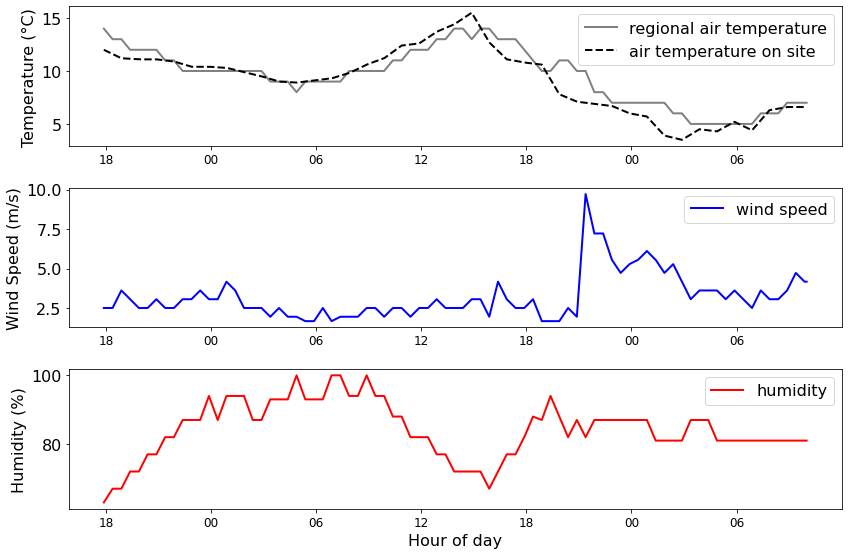

In [5]:
air_temp_add1 = np.insert(air_temp, 0, 12)
air_temp_local = np.interp(np.arange(0, 2408), np.arange(0, len(air_temp_add1) * 60, 60), air_temp_add1)

### use dew point temperature to calculate the relative humidity
dew_temp_add1 = np.insert(dew_temp, 0, 9)
dew_temp_local = np.interp(np.arange(0, 2408), np.arange(0, len(dew_temp_add1) * 60, 60), dew_temp_add1)
r_humidity = 100 * np.exp((17.27 * dew_temp_local) / (dew_temp_local + 237.3)) / np.exp((17.27 * air_temp_local) / (air_temp_local + 237.3))

### regional weather data
csv_file = pd.read_csv(reg_met)
air_temp = csv_file['Temperature'].to_numpy()
wind_speed = csv_file['Wind Speed'].to_numpy()*1000/3600
humidity = csv_file['Humidity'].to_numpy()

air_temp_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(air_temp) * 30, 30), air_temp)
wind_speed_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(wind_speed) * 30, 30), wind_speed)
humidity_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(humidity) * 30, 30), humidity)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True)

# Plot regional air temperature and air temperature on site
ax1.plot(np.arange(2408), air_temp_interpolated, label='regional air temperature', color='gray', lw=2)
ax1.plot(np.arange(2408), air_temp_local, label='air temperature on site', color='k', linestyle='--', lw=2)
ax1.set_ylabel("Temperature (°C)", fontsize=16)
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax, fontsize=12)
ax1.legend()

# Plot wind speed
ax2.plot(np.arange(2408), wind_speed_interpolated, label='wind speed', color='blue', lw=2)
ax2.set_ylabel("Wind Speed (m/s)", fontsize=16)
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=12)
ax2.legend()

# Plot humidity
ax3.plot(np.arange(2408), humidity_interpolated, label='humidity', color='r', lw=2)
ax3.set_xlabel("Hour of day", fontsize=16)
ax3.set_ylabel("Humidity (%)", fontsize=16)
ax3.set_xticks(xax)
ax3.set_xticklabels(hrax, fontsize=12)
ax3.legend()

plt.show()

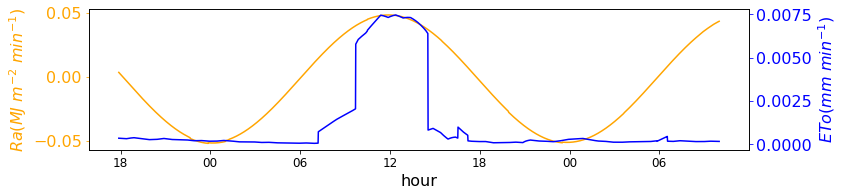

In [6]:
### get the extraterrestrial radiation
lat = 52.78
lon = -2.43
day = 76   ## 17th March
lz = 0  
time = 12.0
duration = 1.0/60  ## 1 minute
rad_a_shortterm(lat, lon, day, lz, time, duration)

rad_every_minute = np.zeros(acqu_time.shape[0])
for imin in range(0, acqu_time.shape[0]):
    day = acqu_time[imin].timetuple().tm_yday
    time = acqu_time[imin].hour + acqu_time[imin].minute/60
    rad_every_minute[imin] = rad_a_shortterm(lat, lon, day, lz, time, 1.0/60)

### get the ETo
rad = np.zeros(2408)
rad[800:950] = 0.25
rad[950:1240] = 0.75
rad[1360:1400] = 0.25
rad[2158:2200] = 0.25
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity)
    
fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.plot(np.arange(acqu_time.shape[0]), rad_every_minute, label='1-minute radiation', color='orange')
ax1.set_xlabel("hour", fontsize=16)
ax1.set_ylabel("$Ra (MJ~m^{-2}~min^{-1})$", fontsize=16, color='orange')
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax, fontsize=12)
ax1.tick_params(axis='y', colors='orange')

ax2 = ax1.twinx()
ax2.plot(np.arange(acqu_time.shape[0]), eto_every_minute, label='1-minute ETo', color='blue')
ax2.set_ylabel("$ETo (mm~min^{-1}$)", fontsize=16, color='blue')
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=12)
ax2.tick_params(axis='y', colors='blue')

fig.tight_layout()
plt.show()

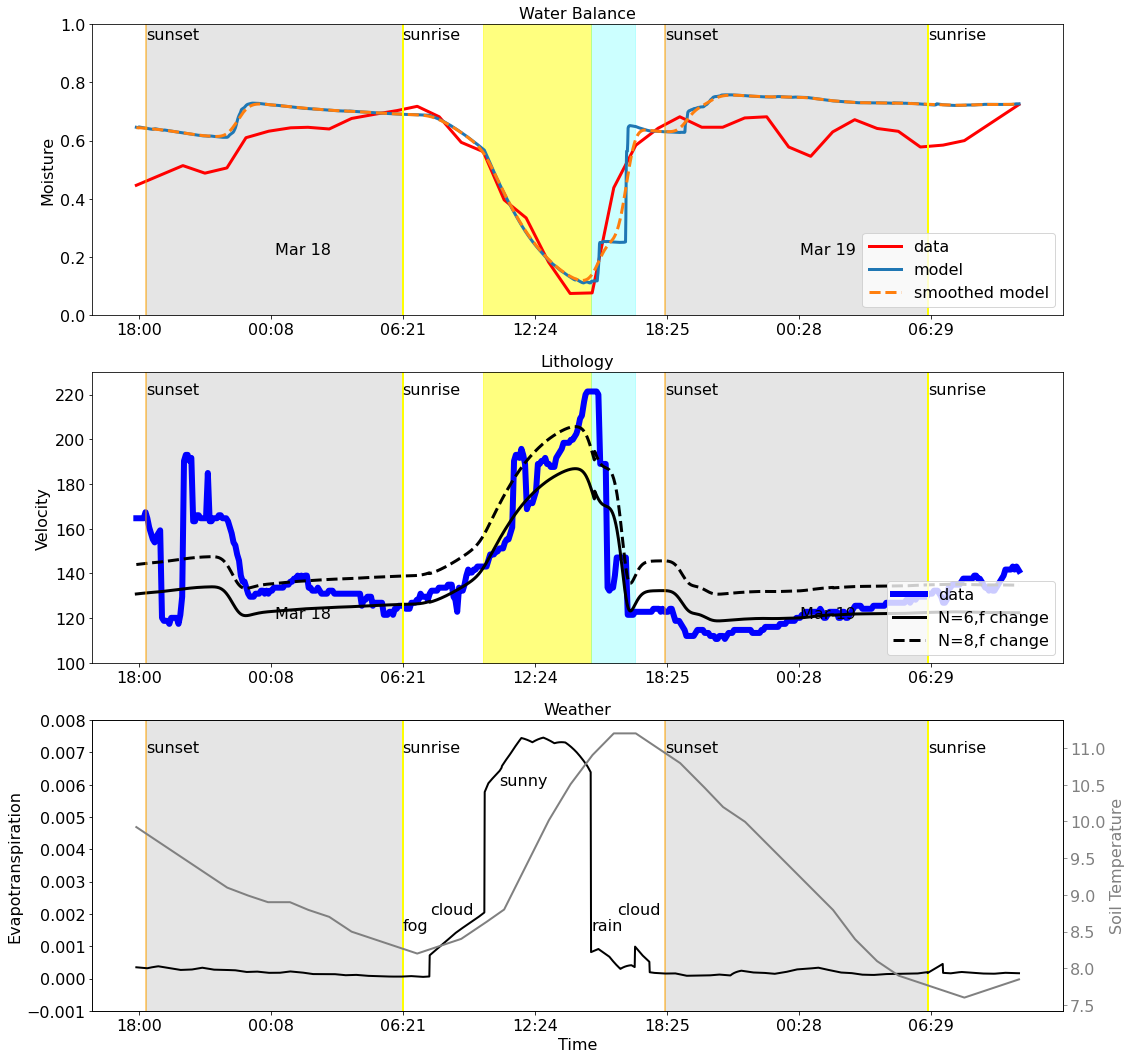

In [51]:
## Model the water balance
A_e = 1
A_d = 0.0004
A_p = 0.26
rad = np.zeros(2408)
rad[800:950] = 0.25
rad[950:1240] = 0.75
rad[1360:1400] = 0.25
rad[2158:2200] = 0.25
rad = rad * rad_every_minute
# eto_every_minute=eto_shortterm(rad, air_temp_interpolated, wind_speed_interpolated*0.75, humidity_interpolated)
eto_every_minute=eto_shortterm(rad, air_temp_local, wind_speed_interpolated*0.75, r_humidity) 

s_history = hydro0(ave_psd, 0.5, s[0], temp, 9, eto_every_minute, damage_index[10], A_p,A_e,A_d).get_s_history()
s_history_smooth = gaussian_filter1d(s_history, sigma=20, mode='reflect')

## Model the lithology
## Input parameters
s_wr = 0.0  ## residual saturation
s=moisture/100*2-1
# scale_factor = moisture/100 * 2.5 - 0.6
scale_factor = (s_history_smooth+1)/2 * 3 - 0.6
new_f = 0.9-scale_factor/2
   
tau1 = 5e6 * np.exp(np.power(s_history_smooth[0:800],3))  ## wetting
tau2 = 1e7 * (1-s_history_smooth[800:1250])  ## drying
tau3 = 5e6 * np.exp(np.power(s_history_smooth[1250:1900],3))  ## wetting
tau4 = 1e7 * (1-s_history_smooth[1900:])  ## drying
tau = np.concatenate((tau1, tau2, tau3, tau4))

s_rate = np.diff(s_history_smooth) / 60 ## Saturation rate, per second
p_diff = 0-np.concatenate((s_rate, [0])) * tau

bulk_density, porosity = 1400, 0.47
vp_sand, vs_sand,   _, _, _ = litho(bulk_density, porosity, 6, new_f, s_history_smooth, s_wr, tau).get_vp_vs()
vp_clay, vs_clay,   _, _, _ = litho(bulk_density, porosity, 8, new_f, s_history_smooth, s_wr, tau).get_vp_vs()


### Plot the water balance
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 15), tight_layout=True)

# Water balance plot
ax1.fill_between(np.arange(2408), 0, 1, where=eto_every_minute > 0.002, color='yellow', alpha=0.5)
ax1.fill_between([1240,1360], [0,0], [1,1], color='cyan', alpha=0.2)
ax1.fill_between([27,726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.plot(np.arange(2408), s-0.2, label='data', color='r', lw=3)
ax1.plot(np.arange(2408), s_history, label='model', lw=3)
ax1.plot(np.arange(2408), s_history_smooth, label='smoothed model', linestyle='--', lw=3)
ax1.set_ylim(0, 1)
ax1.set_ylabel("Moisture", fontsize=16)
ax1.set_xticks(xax)
ax1.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax1.set_title("Water Balance", fontsize=16)
ax1.legend(loc='lower right')
ax1.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.text(27, 0.95, 'sunset', color='k')
ax1.text(726, 0.95, 'sunrise', color='k')
ax1.text(1443, 0.95, 'sunset', color='k')
ax1.text(2158, 0.95, 'sunrise', color='k')
ax1.text(Ind6hrs[1] + 20, 0.21, 'Mar 18', color='k')
ax1.text(Ind6hrs[5] + 30, 0.21, 'Mar 19', color='k')

# Lithology plot
ax2.fill_between(np.arange(2408), 100, 230, where=eto_every_minute > 0.002, color='yellow', alpha=0.5)
ax2.fill_between([1240,1360], [100,100], [230,230], color='cyan', alpha=0.2)
ax2.fill_between([27,726], [100,100], [230,230], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [100,100], [230,230], color='gray', alpha=0.2)
ax2.plot(np.arange(2408), dvv*135, label='data', lw=6, color='b')
ax2.plot(np.arange(2408), vs_sand, label='N=6,f change', color='k', lw=3)
ax2.plot(np.arange(2408), vs_clay, label='N=8,f change', color='k', lw=3, ls='--')
ax2.set_ylabel("Velocity", fontsize=16)
ax2.set_title("Lithology", fontsize=16)
ax2.set_xticks(xax)
ax2.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax2.legend(loc='lower right')
ax2.set_ylim(100, 230)
ax2.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.text(27, 220, 'sunset', color='k')
ax2.text(726, 220, 'sunrise', color='k')
ax2.text(1443, 220, 'sunset', color='k')
ax2.text(2158, 220, 'sunrise', color='k')
ax2.text(Ind6hrs[1] + 20, 120, 'Mar 18', color='k')
ax2.text(Ind6hrs[5] + 30, 120, 'Mar 19', color='k')

# Weather data plot
ax3.fill_between([27,726], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.fill_between([1443,2158], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax3.set_ylim(-0.001, 0.008)
ax3.text(726, 0.0015, 'fog', color='k')
ax3.text(800, 0.002, 'cloud', color='k')
ax3.text(990, 0.006, 'sunny', color='k')
ax3.text(1240, 0.0015, 'rain', color='k')
ax3.text(1310, 0.002, 'cloud', color='k')
ax3.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax3.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax3.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax3.text(27, 0.007, 'sunset', color='k')
ax3.text(726, 0.007, 'sunrise', color='k')
ax3.text(1443, 0.007, 'sunset', color='k')
ax3.text(2158, 0.007, 'sunrise', color='k')
ax3.plot(np.arange(2408), eto_every_minute, color='k', lw=2, label='ET rate')
ax3.set_xticks(xax)
ax3.set_xticklabels([t.strftime('%H:%M') for t in tax], fontsize=16)
ax3.set_xlabel("Time", fontsize=16)
ax3.set_ylabel("Evapotranspiration", fontsize=16)
ax3.set_title("Weather", fontsize=16)

twinx = ax3.twinx()
twinx.plot(np.arange(2408), temp, color='gray', lw=2, label='temperature')
twinx.set_ylabel("Soil Temperature", fontsize=16, color='gray')
twinx.tick_params(axis='y', colors='gray')

plt.tight_layout()
plt.show()


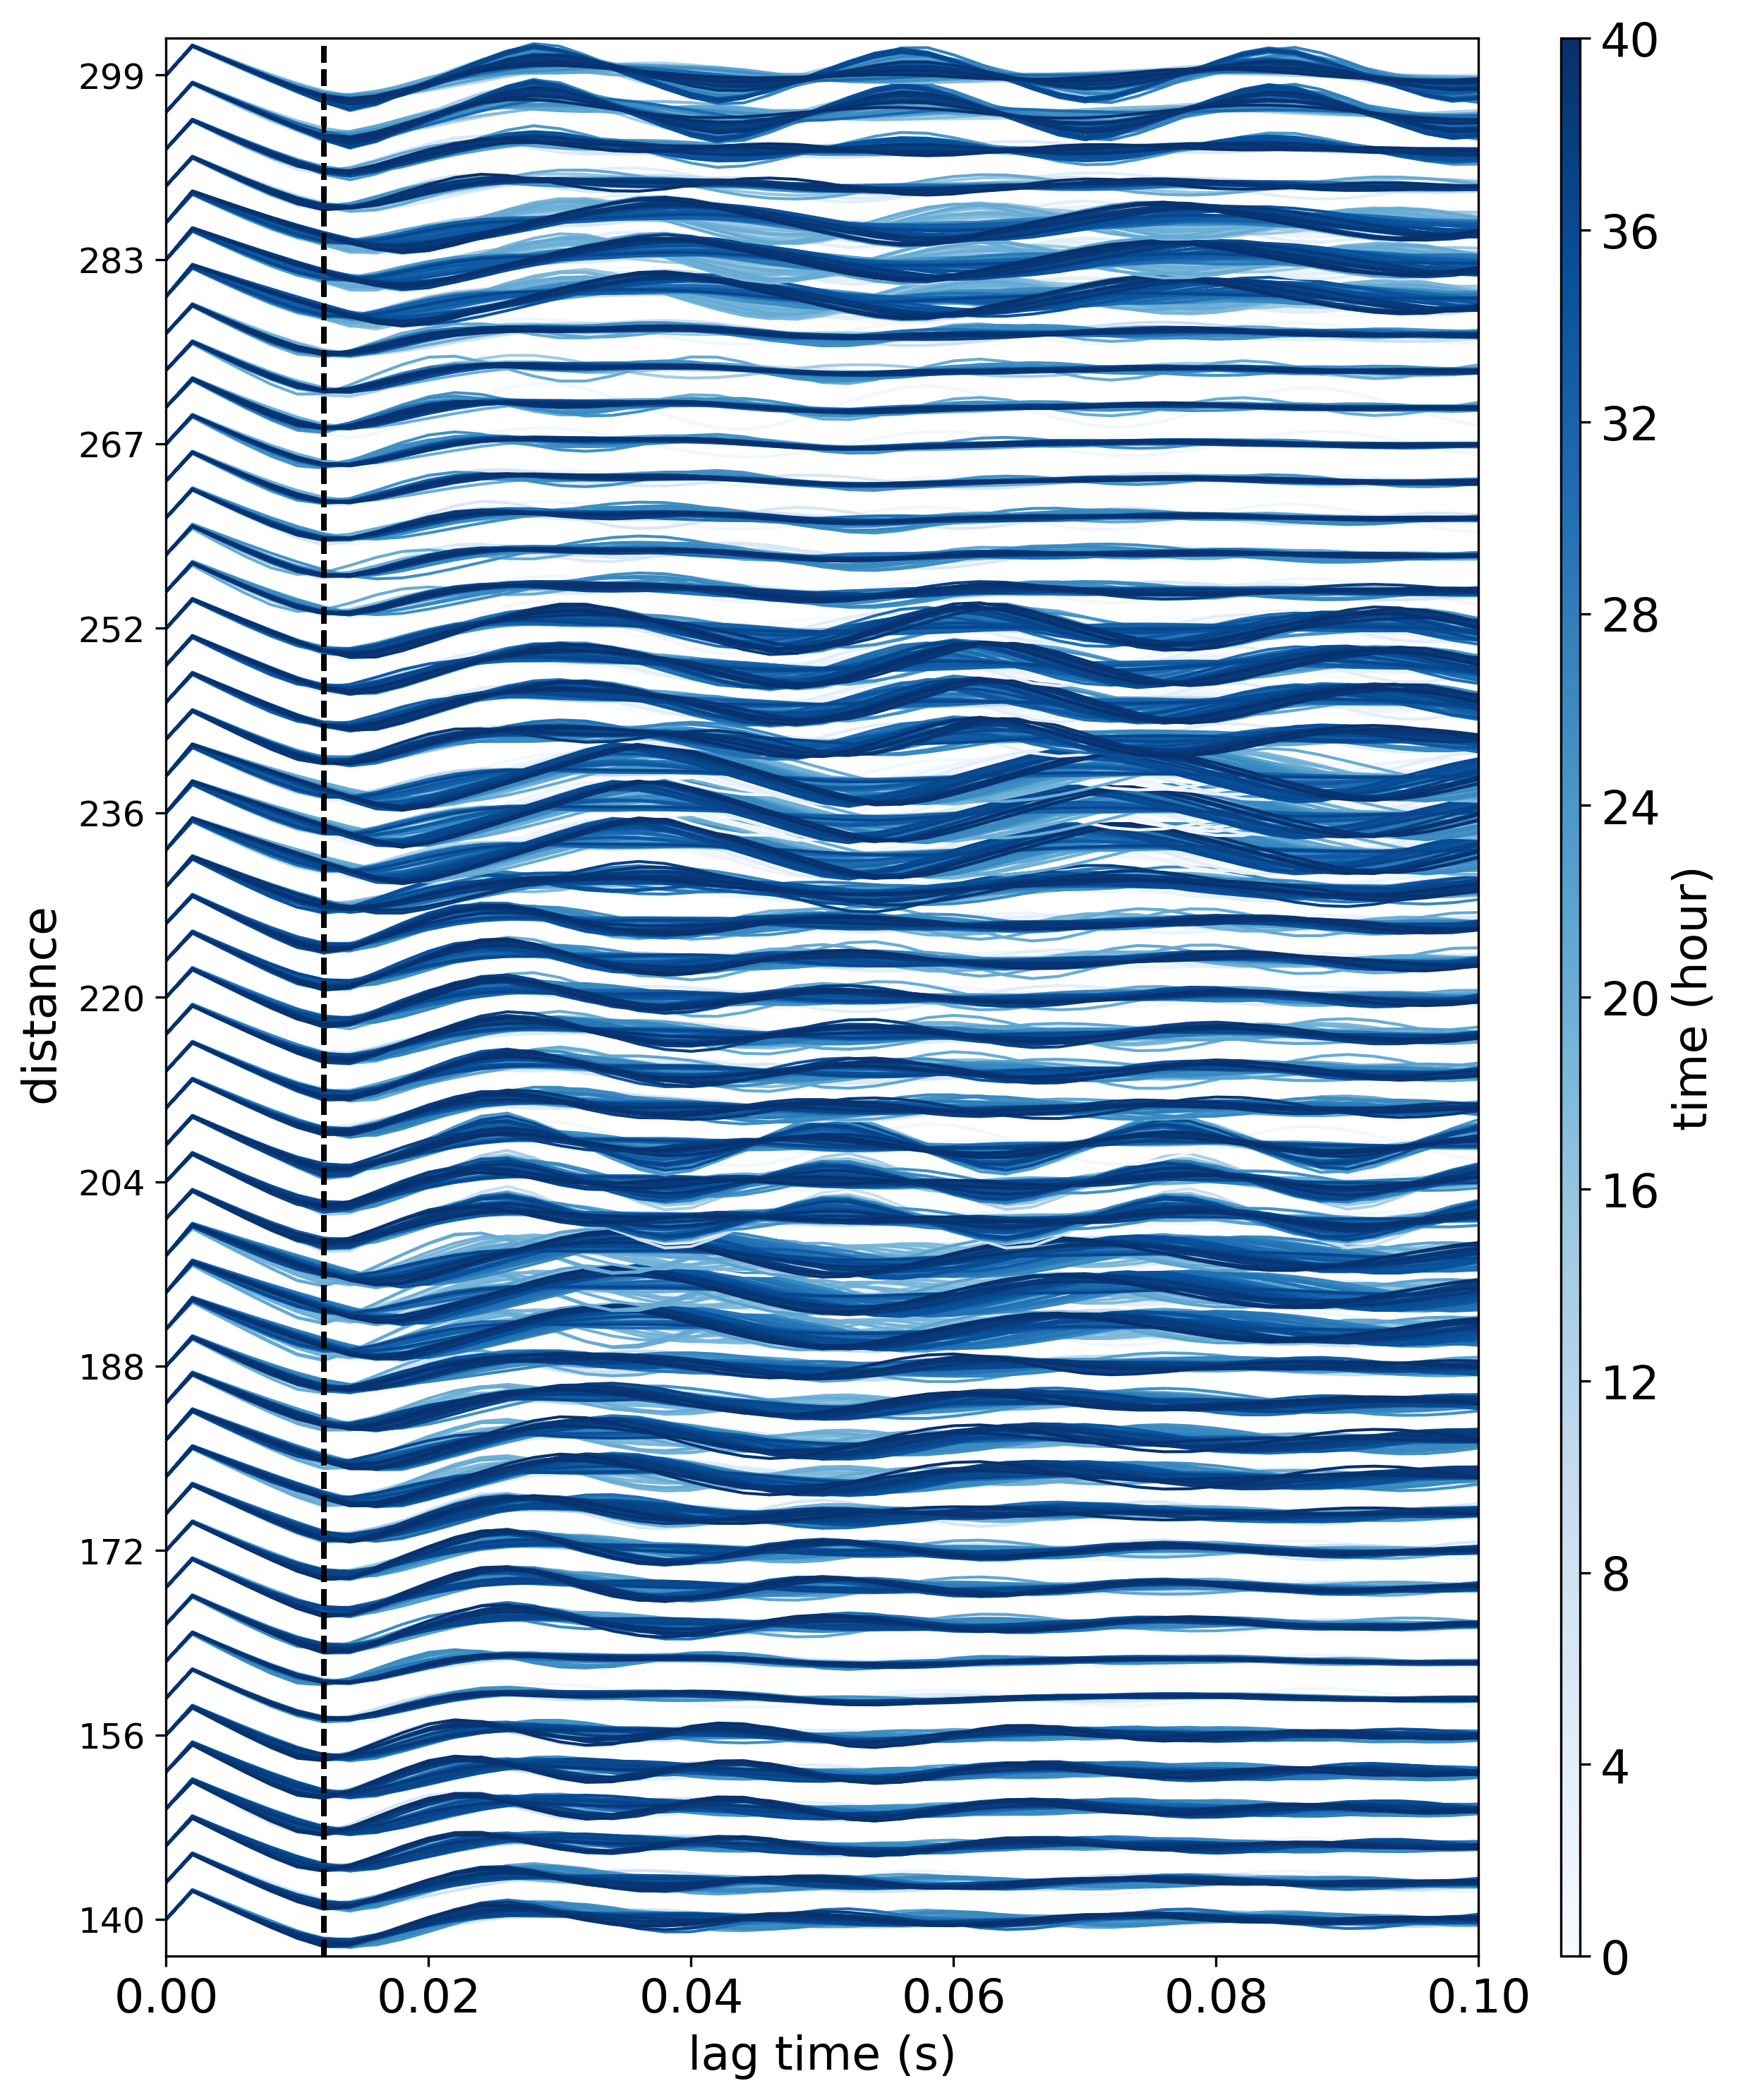

In [8]:
samp_freq = 500
win_st = int(0.012*samp_freq)

with h5py.File('/fd1/QibinShi_data/England_farm/autocorr_25_50Hz.hdf5', 'r') as f:
    corr_all_time = f['autocorr'][:, :, 2500:2625, 0]
    
plt.figure(figsize = (10, 12), dpi = 300)
plt.xlim(0, 0.1)
plt.ylim(43, 95)
plt.ylabel('distance ', fontsize=16)
for iloc in np.arange(0,51,1):
    data_plot=corr_all_time[iloc].T
    x=np.arange(data_plot.shape[1])
    y=np.arange(data_plot.shape[0])

    
    for i in x[::5]:
        plt.plot(y/samp_freq, data_plot[:,i]*1.1+iloc+44, color=plt.cm.Blues(i / len(x)), lw=1)

    # plt.plot(y/samp_freq, np.mean(data_plot+iloc, axis=1), c='k', lw=9, alpha=0.3)

    plt.xlabel('lag time (s)')
    plt.axvline(x=win_st/samp_freq, color='k', linestyle='--', label='1st reflection')

plt.yticks(np.arange(44,95,5), (np.arange(44,95,5)*3.19).astype(int), fontsize = 12)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), label='time (hour)', aspect=100)
cbar.set_ticks(np.linspace(0, 1, num=11))
cbar.set_ticklabels(np.linspace(0, 40, num=11).astype(int))


## Inversions

### Step 1: lithological

In [44]:
## Forward model predicting next-minute velocity
class litho_1:
    def __init__(self, bulk_density, porosity, N, f, s0, s_rate, s_wr, tau, igore_capillary=False):
        self.rho_d = bulk_density
        self.phi = porosity  ## derived from rho_d, actually
        self.N = N  ## number of contacts
        self.f = f  ## non-slip fraction
        self.s0 = s0  ## Saturation from the previous minute
        self.s_rate = s_rate ## rate per sec
        self.s = self.s0 + self.s_rate * 60 ## Saturation at the current minute
        self.s_wr = s_wr  ## residual saturation
        self.tau = tau  ## dynamic coefficient of capillary pressure

        ## Solid grains
        self.rho_s = 2650 # kg/m^3
        self.K_s = 37e9 # Pa
        self.G_s = 44e9 # Pa

        ## Water
        self.rho_w = 1000
        self.K_w = 2.2e9  ## by Copilot

        ## Air
        self.rho_a = 1.2  ## kg/m^3
        self.K_a = 1e5  ## by Copilot

        ## Water-air mixture
        self.K_f = 1 / (self.s / self.K_w  +  (1-self.s) / self.K_a)

        ## Effective density of the soil
        self.rho = (1-self.phi)*self.rho_s + self.phi*(self.s*self.rho_w + (1-self.s)*self.rho_a)

        ## Capillary and pore pressure
        if igore_capillary:  ## typical for fully saturated soil
            P_e = (self.rho - self.rho_w) * 9.8 * 0.1
        else:
            kai = (self.s - self.s_wr) / (1 - self.s_wr)
            P_cdiff = self.s_rate * self.tau
            P_e = (self.rho - self.rho_a) * 9.8 * 0.1 - (self.rho_w - self.rho_a) * 9.8 * 0.1 * kai - P_cdiff

        ## Moduli of frame (Hertz-Mindlin) 
        nu = (3*self.K_s-2*self.G_s)/(2*(3*self.K_s+self.G_s))  ## Poisson's ratio
        self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
        self.G_d = 3 * self.K_d * (2+3*self.f-(1+3*self.f)*nu) / (2 - nu) / 5
        

    def get_vp_vs(self):
        
        self.K = self.K_d + (1-self.K_d/self.K_s)**2 / (self.phi/self.K_f + (1-self.phi)/self.K_s - self.K_d/self.K_s**2)
        self.G = self.G_d
        self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)
        self.vs = np.sqrt(self.G/self.rho)
    

        return self.vp, self.vs, self.K, self.G, self.rho, self.s

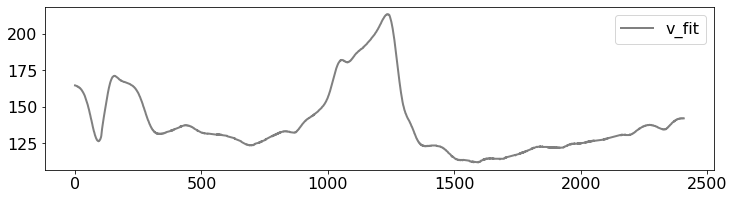

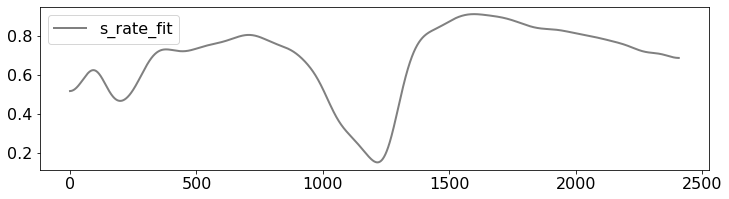

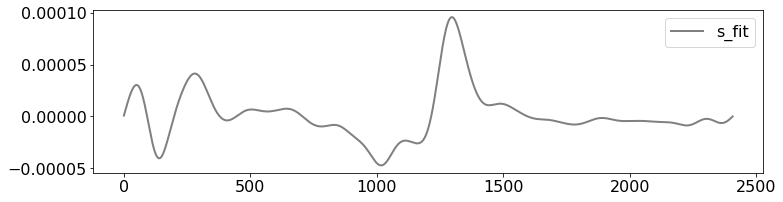

In [101]:
s0 = 0.5
v = []
s_rate_inv = []
s_inv = []

dvv_smooth = gaussian_filter1d(dvv, sigma=20, mode='reflect')

for i in range(2408):
    ds_space = np.arange(-0.02, 0.02, 0.0001)
    obj_func = np.zeros_like(ds_space)
    vs_clay = np.zeros_like(ds_space)
    s_rates = np.zeros_like(ds_space)
    for ii, ds in enumerate(ds_space):
        s = ds  + s0
        if s < 0:
            s = 0
        if s > 1:
            s = 1
        s_rates[ii] = (s - s0) / 60
        
        scale_factor = (s+1)/2 * 3 - 0.6
        new_f = 0.9-scale_factor/2

        if s_rates[ii] > 0:
            tau = 5e6 * np.exp(np.power(s,3))  ## wetting
        else:
            tau = 1e7 * (1-s)  ## drying

        _, vs_clay[ii],   _, _, _, _ = litho_1(bulk_density, porosity, 8, new_f, s, s_rates[ii], s_wr, tau).get_vp_vs()
        obj_func[ii] = (dvv_smooth[i]*135 - vs_clay[ii]) ** 2

    best_idx = np.argmin(obj_func)
    if np.isnan(vs_clay[best_idx]):
        best_idx = np.nanargmin(obj_func)

    s = s0 + s_rates[best_idx] * 60
    scale_factor = (s+1)/2 * 3 - 0.6
    new_f = 0.9-scale_factor/2

    if s_rates[ii] > 0:
        tau = 5e6 * np.exp(np.power(s,3))  ## wetting
    else:
        tau = 1e7 * (1-s)  ## drying


    _, vs_best,   _, _, _, s0 = litho_1(bulk_density, porosity, 8, new_f, s, s_rates[best_idx], s_wr, tau).get_vp_vs()
    print(best_idx, vs_best, )
    v.append(vs_best)
    s_rate_inv.append(s_rates[best_idx])
    s_inv.append(s0)

s_inv_smooth = gaussian_filter1d(s_inv, sigma=40, mode='reflect')
s_rate_inv_smooth = np.append(np.diff(s_inv_smooth) / 60, [0])

plt.figure(figsize=(12, 3))
plt.plot(np.arange(2408), v, label='v_fit', color='gray', lw=2)
plt.legend()

plt.figure(figsize=(12, 3))
plt.plot(np.arange(2408), s_inv_smooth, label='s_rate_fit', color='gray', lw=2)
plt.legend()

plt.figure(figsize=(12, 3))
plt.plot(np.arange(2408), s_rate_inv_smooth, label='s_fit', color='gray', lw=2)
plt.legend()


### Step 2: hydrological

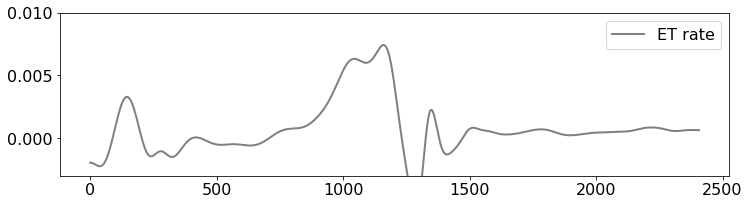

In [102]:
### Backward model using s_history to calculate the ET rate
class hydro1:
    def __init__(self, prec, porosity, s_inv, s_rate_inv, T, I, damage_index, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s_inv
        self.s_rate = s_rate_inv
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.damage = damage_index
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length


    def get_evap(self):
        prec_rate = self.A_p * self.prec

        ## drainage
        self.drain = self.prec * self.s * self.damage  ## Drainage rate
        drain_rate = self.A_d * self.drain

        evap_rate = prec_rate - drain_rate - self.s_rate

        ## evaporation
        self.evap = evap_rate / self.A_e 
        self.etc = self.evap / (self.s * self.damage) ## Evaporation rate
        

        return self.etc
    

A_e = 1
A_d = 0.0004
A_p = 0.26

psd_smooth = gaussian_filter1d(ave_psd, sigma=1, mode='reflect')
etc_rate = hydro1(psd_smooth, 0.5, s_inv_smooth, s_rate_inv_smooth * 60, temp, 9, damage_index[10], A_p,A_e,A_d).get_evap()
etc_smooth = gaussian_filter1d(etc_rate, sigma=30, mode='reflect')

plt.figure(figsize=(12, 3))
plt.plot(np.arange(2408), etc_smooth, label='ET rate', color='gray', lw=2)
plt.ylim(-0.003, 0.01)
plt.legend()